In [2]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Next-Generation Astronomical Transient Classification via Large Language Models

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/turanbulmus/spacehack/blob/main/01%20-%20Prompt%20Engineering.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2Fturanbulmus%2Fspacehack%2Fmain%2F01%20-%20Prompt%20Engineering.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/turanbulmus/spacekhack/main/01%20-%20Prompt%20Engineering.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/turanbulmus/spacehack/blob/main/01%20-%20Prompt%20Engineering.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| Authors |\
| Turan Bulmus | https://github.com/turanbulmus | \
| Fiorenzo Stoppa | https://github.com/FiorenSt |


### Set Google Cloud environment variables information and initialize Clients

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).
To get started using Vertex AI, you must have an existing Google Cloud project and the following:
* [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). 
* [Enable the Big Query API](https://console.cloud.google.com/flows/enableapi?apiid=bigquery.googleapis.com).

In [3]:
PROJECT_ID = "turan-genai-bb"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}
EXPERIMENT_NAME = "supernovadetection" # @param {type:"string"}
# Make sure that dataset is created in Big Query
DATASET_ID = "spacehack" # @param {type:"string"}
import vertexai
from google.cloud import bigquery


vertexai.init(project=PROJECT_ID, location=LOCATION, experiment=EXPERIMENT_NAME)
bq_client = bigquery.Client(project=PROJECT_ID)

/home/user/spacehack/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


/home/user/spacehack/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


## Import libraries and define helper functions

In [4]:
import gdown 
import base64
import json
import random, os
import time, datetime
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from vertexai.generative_models import GenerativeModel, Part, FinishReason, Image
from google.cloud import bigquery
import google.cloud.aiplatform as aiplatform

from helper_functions import build_run_batch, if_tbl_exists, create_ex, save_picture, save_prompt, build_experiment_vars

In [5]:
PERSONA = """<PERSONA>
You are an experienced astrophysicist, and your task is to classify astronomical transients into Real or Bogus based on a given set of 3 images. You have seen thousands of astronomical images during your lifetime and you are very good at making this classification by looking at the images and following the instructions.
</PERSONA>"""

TASK = """<TASK>
Your task is to read the INSTRUCTIONS, look at the 3 images (New, Reference and Difference images) and classify if the source at the centre of the cutout and inside the red circle is a Real or Bogus astronomical transient. Provide your thought process to explain how you reasoned to provide the response. Respond in json format
</TASK>\n
"""

INSTRUCTIONS = """\n<INSTRUCTIONS>
**1. Purpose**
Help vet astronomical data for the Real/Bogus classification. The goal is for you to use your expertise to distinguish between real and bogus sources. 

**2. Information Provided**
You will be shown three astronomical image cutouts:
a) **New Image:** The newest image centered at the location of the suspected transient source. 
b) **Reference Image:** A reference image from the same telescope of the same part of the sky to be used for comparison. It shows if the source was already there in the past or not.
c) **Difference Image:** The residual image after the new and reference images are subtracted. Real sources should appear in this cutout as circular objects with only positive (white pixels) flux. 

**3. Criteria for Classification**
- **Real Source:** 
  - **Shape:** Circular shape at the center of the cutout with a visual extent of ~2-6 pixels, varying with focus conditions.
  - **Brightness:** Positive flux source (white pixels) in the New image. Positive flux source in the Difference image. 
  - **Presence:** A real source will appear in the New image. This source can either be a supernova on a galaxy or a cataclysmic variable.

- **Bogus Source:** 
  - **Shape:** Non-circular shape (e.g., elongated). This includes irregular shapes, positive or negative, like streaks or lines caused by cosmic-rays, diffraction spikes and cross-talk.
  - **Brightness:** Source not present or too faint at the center of the cutout. The source at the center can never be negative in the Difference image.

**4. Additional Guidance** 
- **Contextual Information:** Focus on the source at the center of the cutouts inside the red circle, but consider nearby sources to diagnose potential problems.  
- **Examples:** Refer to provided visual examples of real and bogus sources to aid in identification. 
- **Judgment Criteria:** For ambiguous cases or borderline scenarios, consider the overall context and consistency with known characteristics of real and bogus sources.
</INSTRUCTIONS>"""


METHOD = """<METHOD>
1. **Focus on the Red Circle**: Start by examining the source located at the center of the cutout and inside the red circle. The images are prepared so that the source of interest is clearly marked for you to analyze.

2. **Analyze Each Image Individually**:
   - **New Image**: Check for the presence, shape, and brightness of the source in the New image.
   - **Reference Image**: Compare the source's properties in the Reference image to those in the New image.
   - **Difference Image**: Observe the residuals that result from subtracting the reference image from the New image. Look for patterns (circular, positive flux) that match characteristics of Real sources.

3. **Evaluate Features**:
   - Examine the shape, brightness, and other relevant features (e.g., artifacts, misalignments) of the source in each image.
   - Determine if these features are consistent with a Real or Bogus classification based on the criteria provided in the instructions.

4. **Consider Relationships Between Images**:
   - Compare the New, Reference, and difference images to understand any changes in the source over time.
   - Look for discrepancies or confirmations that might support or contradict a particular classification.

5. **Employ a Chain-of-Thought Reasoning**:
   - Clearly outline each observation you make and explain how it contributes to your decision-making process.
   - If you find any contradictions or ambiguous features, acknowledge them and provide reasoning for your final decision.

6. **Assign an Interest Score**:
   - After determining if the source is Real or Bogus, assign an appropriate interest score:
     - 'No interest' for Bogus sources.
     - 'Low interest' for cataclysmic transients.
     - 'High interest' for explosive transients.

7. **Prepare the Final Output in JSON Format**:
   - Format your response as a JSON object containing:
     - The classification ('Real' or 'Bogus').
     - An explanation detailing your thought process and observations.
     - The assigned interest score.

8. **Example Output**:
   - Refer to the provided examples to see the expected format and detail level of your response.
</METHOD>
"""

# Collapse the System Instructions into a single variable
stat_prompt = PERSONA + TASK + INSTRUCTIONS + METHOD


In [6]:
import pandas as pd
import numpy as np
import os

# Load the dataset
file_path_data = '/home/user/spacehack/ATLAS_dataset/ATLAS_images.npy'
file_path_labels_csv = '/home/user/spacehack/ATLAS_dataset/ATLAS_labels.csv'

triplets = np.load(file_path_data)

# Load labels from CSV file
labels_df = pd.read_csv(file_path_labels_csv)

# Upload Labels to BigQuery
labels_id = "ATLAS_labels_df"
labels_ref = bq_client.dataset(DATASET_ID).table(labels_id)
create_table_flag = if_tbl_exists(bq_client, labels_ref)

if create_table_flag != True:
    bq_client.load_table_from_dataframe(labels_df, labels_ref)

# Sample indexes for saving pictures
sample_indexes = [0, 1, 2, 3, 4, 8, 9, 1001, 1003, 1007, 1011, 1017, 1024]

# Load train data directly from the dataset already loaded
train_data = triplets  # No need to download or reload; reuse the loaded data

# Save pictures for sample indexes
for i in sample_indexes:
    save_picture(train_data, i, True)

# Handle dynamic part of the prompt and save pictures
batch_index = np.where(~np.isnan(triplets).any(axis=(1, 2, 3)))[0]  # remove corrupt data
for t in batch_index:
    save_picture(triplets, t, False)

In [7]:
## DESCRIPTION INDEX 0:
desc1 = {
  "class": "Real",
  "explanation": "The New image shows a faint small source at the center. The Reference image shows a faint elongated source in the same location. The Difference image shows a consistent faint positive residual, indicating this is a real transient.",
  "interest_score": "High interest"
}


## DESCRIPTION INDEX 1:
desc2 = {
  "class": "Real",
  "explanation": "The New image shows a bright source at the center, of a size consistent with all the other sources in the image. The Reference image shows that a source was already present at the centre of the cutout. The Difference image shows a faint positive residual suggesting the source is a real transient.",
  "interest_score": "High interest"
}


## DESCRIPTION INDEX 2:
desc3 = {
  "class": "Real",
  "explanation": "The New image shows a source at the center of the cutout, close to mulitple other sources. The Reference image shows a source in the same location. The Difference image has mulitple sources with a yin-yang pattern, however the source at the centre has only a positive residual indicating this is a real transient.",
  "interest_score": "High interest"
}


## DESCRIPTION INDEX 3:
desc4 = {
  "class": "Real",
  "explanation": "The New image shows a bright circular source at the center, lying on top of a small diffuse galaxy. The Reference image shows the same galaxy, but not the source in the same location as the New image. The Difference image displays a positive circular residual at the centre, this is likely a supernova.",
  "interest_score": "High interest"
}


## DESCRIPTION INDEX 4
desc5 = {
  "class": "Real",
  "explanation": "The New image shows a really small (just 2 pixels) source, possibly on top of a really big and outside of the cutout galaxy. The Reference image shows no source at the centre, but the full image shows a diffuse background, potentially a galaxy. The Difference image shows a really small (2 pixels) positive residual at the centre, confirming this is a supernova on a galaxy.",
  "interest_score": "High interest"
}


## DESCRIPTION INDEX 8
desc6 = {
  "class": "Real",
  "explanation": "The New image shows a bright galaxy, an additional source is not easily visible since the galaxy is really bright. The Reference image shows the same galaxy as in the New image. The Difference has a small positive residual source at the centre confirming this is a supernova on the galaxy.",
  "interest_score": "High interest"
}



## DESCRIPTION INDEX 9:
desc7 = {
  "class": "Real",
  "explanation": "The New image shows a really faint source at the centre (2 pixels), close to another small source that could be a galaxy. The Reference image shows no source at the same central location, but it does show other sources also present in the New image. The Difference image shows a faint but positive residual source, this is a real transient.",
  "interest_score": "High interest"
}


## DESCRIPTION INDEX 1001:
desc8= {
  "class": "Bogus",
   "explanation": "The New image does not show any source at the center, but there is a source slighlty off centre. The Reference image also does not show any source in the same location, but it does show other sources. The Difference has an off centre source with both positive and negative residuals, this confirms it is not a real transient.",
  "interest_score": "No interest"
}


## DESCRIPTION INDEX 1003:
desc9 = {
  "class": "Bogus",
  "explanation": "The New image shows an elongated source cause by a diffraction spike of a bright source to the left. The same diffraction spike is also visible in the Reference image in the same location. The Difference image shows an elongated residual source due to the diffraction, this is a bogus source.",
  "interest_score": "No interest"
}



## DESCRIPTION INDEX 1007:
desc10 = {
  "class": "Bogus",
  "explanation": "The New image shows an elongated source cause by a diffraction spike of a bright source to the bottom left. The same diffraction spike is also visible in the Reference image in the same location. The Difference image shows both a masked region and an elongated residual source due to the diffraction, this is a bogus source.",
  "interest_score": "No interest"
}



## DESCRIPTION INDEX 1011:
desc11= {
  "class": "Bogus",
   "explanation": "The New image shows a vertical source passing through the centre of the cutout caused by saturation of the star at the bottom. The Reference image shows the same vertical feature. The Difference shows the same faint vertical residual cause by saturation, this is artifacts and not a real source.",
  "interest_score": "No interest"
}


## DESCRIPTION INDEX 1017:
desc12= {
  "class": "Bogus",
   "explanation": "The New image shows no clear source at the centre of the cutout. The Reference image shows a source slightly off centre. The Difference image shows a bad subtraction source with both positive and negative pixels, this is a bogus.",
  "interest_score": "No interest"
}


## DESCRIPTION INDEX 1024:
desc13= {
  "class": "Bogus",
   "explanation": "The New image does not show a clear source at the centre, only a vertical feature caused by the bright star at the bottom. The Reference does not show any source at the centre. The difference image shows the same vertical feature caused by th bright star reaching the centre of the cutout, this is a bogus source.",
  "interest_score": "No interest"
}




descriptions = [str(desc1), str(desc2), str(desc3), str(desc4), str(desc5), str(desc6),str(desc7), str(desc8), str(desc9), str(desc10), str(desc11), str(desc12), str(desc13)]

### Write the examples used in a readable format to be saved as a txt file for tracebility
example_description = list(zip(["DESCRIPTION INDEX: " + str(x) for x in sample_indexes], descriptions))

In [8]:
# Report 15 examples for the dynamic prompt
EXAMPLES = ["<EXAMPLES>\n"]
for i in range(len(sample_indexes)):
    
    str_EX = f"""Example {i+1}:
    """
    all_list = create_ex(sample_indexes[i], True)
    all_list.insert(0, str_EX)
    all_list.append(descriptions[i])
    all
    for k in all_list:
        EXAMPLES.append(k)
EXAMPLES.append("\n</EXAMPLES>\n")

In [9]:
# Start logging the experiment

## Prepare the variables
timestamp = datetime.datetime.now()
formatted_datetime = timestamp.strftime('%Y%m%d%H%M')


## Log the experiments variables
### Create the run name with timestamp
run_name = "run" + formatted_datetime
DESCRIPTION = """Changed the dataset to ATLAS.
The hyperparameters are: 
Temperature: .8
Top P: 1
""" # @param {type:"string"}
MODEL = "gemini-1.5-pro-001" # @param [gemini-1.5-pro-001", "gemini-1.5-flash-001", "gemini-1.0-pro-002"]
TEMPERATURE = .8 # @param {type:"slider", min:0, max:2, step:0.1}
TOP_P = 1 # @param {type:"slider", min:0, max:1, step:0.05}
PROMPT_FILE = save_prompt(stat_prompt + '\n'.join([a + "\n" + b + "\n" for (a,b) in example_description]), run_name)

# Build the experimentation variables
exp_vars = build_experiment_vars(description=DESCRIPTION,prompt=PROMPT_FILE, model=MODEL, temperature=TEMPERATURE, top_p=TOP_P)
# Start the run
aiplatform.start_run(run_name)
# Log the experiment variables
aiplatform.log_params(exp_vars)

Associating projects/355771430623/locations/us-central1/metadataStores/default/contexts/supernovadetection-run202409242134 to Experiment: supernovadetection


In [10]:
# Build and then the batch run requests
pred_df = build_run_batch(bq_client, batch_index, labels_ref, PROJECT_ID, DATASET_ID, run_name, MODEL, stat_prompt, EXAMPLES, TEMPERATURE, TOP_P)

BatchPredictionJob projects/355771430623/locations/us-central1/batchPredictionJobs/4344859938212806656 current state:
1
BatchPredictionJob projects/355771430623/locations/us-central1/batchPredictionJobs/4344859938212806656 current state:
1
BatchPredictionJob projects/355771430623/locations/us-central1/batchPredictionJobs/4344859938212806656 current state:
1
BatchPredictionJob projects/355771430623/locations/us-central1/batchPredictionJobs/4344859938212806656 current state:
1
BatchPredictionJob projects/355771430623/locations/us-central1/batchPredictionJobs/4344859938212806656 current state:
1
BatchPredictionJob projects/355771430623/locations/us-central1/batchPredictionJobs/4344859938212806656 current state:
1
BatchPredictionJob projects/355771430623/locations/us-central1/batchPredictionJobs/4344859938212806656 current state:
1
BatchPredictionJob projects/355771430623/locations/us-central1/batchPredictionJobs/4344859938212806656 current state:
1
BatchPredictionJob projects/355771430623

In [11]:
download_query = f"""
  SELECT index_no, actual, predicted, explanation, interest_score
  FROM turan-genai-bb.spacehack.run202409242134"""
bq_client.query_and_wait(download_query)

<Figure size 640x480 with 0 Axes>

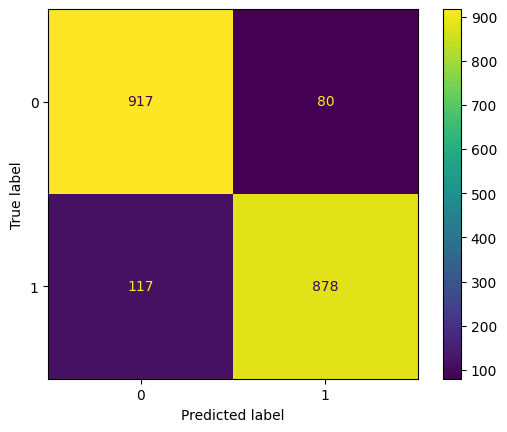

Accuracy is 0.9011044176706827
Precision is 0.9197592778335005
Recall is 0.8868471953578336


In [12]:
# Generate the confusion matrix for the results
plt.clf()
pred_cleaned = pred_df[(pred_df.predicted == "Real") | (pred_df.predicted == "Bogus")]
cm = confusion_matrix(pred_cleaned.actual, pred_cleaned.predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
# Calculate TP, TN, FP, FN
TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
# Print the metrics
print(f"Accuracy is {(TN+TP)/(TN+TP+FP+FN)}")
print(f"Precision is {TP/(TP+FP)}")
print(f"Recall is {TP/(TP+FN)}")

In [13]:
# Log the KPI and conclude the experiment
aiplatform.log_metrics(build_experiment_vars(accuracy=(TN+TP)/(TN+TP+FP+FN), precision=TP/(TP+FP), recall=TP/(TP+FN)))
aiplatform.end_run()

In [ ]:
Accuracy is 0.9011044176706827
Precision is 0.9197592778335005
Recall is 0.8868471953578336

: 